In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import plotly
import plotly.graph_objs as go
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import shap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean, cosine

In [28]:
df = pd.read_csv('../datasets/bank_dataset.csv')
df.head()

,Unnamed: 0,Date,label,text,BankName,processed
0,0,2017-04-10,1,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job person professional and help move th...
1,1,2017-02-10,1,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,professional and helpful help find correct pro...
2,2,2017-08-21,1,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,past experience with and would without questio...
3,3,2017-12-17,1,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,deal with from beginning of start out to very ...
4,4,2016-05-27,1,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,can t express how grateful for support Zach pr...


In [29]:
df.shape

(397, 6)

In [30]:
go.Figure(data=[go.Histogram(x=df['label'])], layout=go.Layout(height=300, width=400))

In [31]:
x = df['text'].values
y = df['label'].values

#### Word representation
We are going to use TF*IDF (Term frequency- Inverse document frequency) vectorizer to convert our text into numbers.
TF = Frequency of term
IDF = No of docs/ No of docs with the term

In [32]:
tfid = TfidfVectorizer(max_features=5000)
x = tfid.fit_transform(x).toarray()
x.shape

(397, 2665)

#### Splitting data
We split data as follows:
- train = 20%
- test = 20%
- unlabelled pool = 60% (this is the data which we want the domain expert to label)

In [33]:
np.random.seed(50)
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.7*x.shape[0])]
test_indices = indices[round(0.5*x.shape[0]): round(0.7*x.shape[0])]
pool_indices = indices[round(0.7*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[test_indices]['text'].values
df_pool = df.iloc[pool_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]
x_pool = x[pool_indices]
y_pool = y[pool_indices]

#### Model fitting
We are going to use Logistic regression with L1 regularization. Reasons for L1:
- We are going to apply shapely values - L1 => sparse model => better for interpretability
- We prefer a sparse model because not all features are important (feature selection)
- It results in better accuracy in this case

In [34]:
C = 0.5
max_iter = 1000
model = SVC( max_iter=max_iter, C=C, kernel='linear', class_weight='balanced')
model.fit(x_train, y_train)
model.score(x_train,y_train)

1.0

We measure the f1_score and plot confusion matrix. Recall:
- f1 score = 2PR/ (P+R)
- P = actual pos/ predicted pos
- R = predicted pos/ total actual pos

In [35]:
predictions = model.predict(x_pool)
f1_score(predictions,
         y_pool)

0.9947089947089947

In [36]:
accuracy_score(y_pool, predictions)

0.9915966386554622

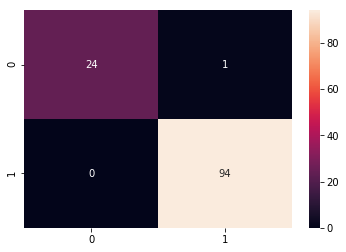

In [37]:
sns.heatmap(confusion_matrix(y_pool, predictions),annot=True)

In [38]:
np.array(np.unique(y_pool, return_counts=True)).T

array([[ 0, 25],
       [ 1, 94]], dtype=int64)

#### SHAP explainer

Refer https://christophm.github.io/interpretable-ml-book/shap.html

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features

We call the SHAP explainer for linear models
shapely values produced have same dimensions as data passed

In [39]:
explainer = shap.LinearExplainer(model, x_train,feature_dependence="independent")
shap_values_train = explainer.shap_values(x_train)
shap_values_pool = explainer.shap_values(x_pool)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [40]:
# # Explain a single positive prediction
# postive_index = 10
# index = np.where(predictions==1)[0][postive_index]
# print("text ", df_test[index], " prediction: ", predictions[index], "actual ", y_test[index])
# shap.force_plot(explainer.expected_value, 
#                                shap_values_pool[index,:], 
#                                x_test[index,:], feature_names = tfid.get_feature_names(),
#                matplotlib=True)

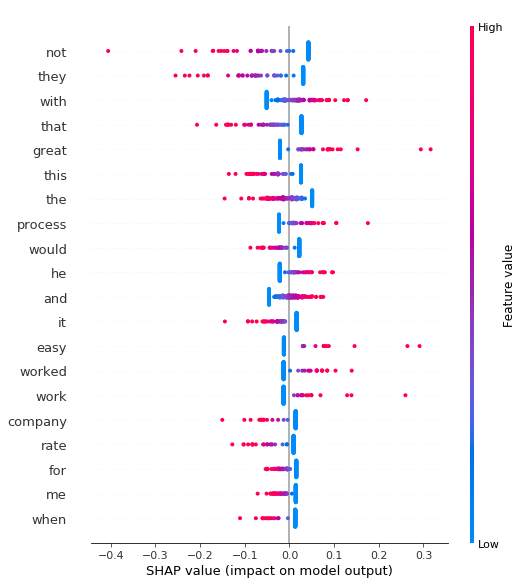

In [41]:
shap.summary_plot(shap_values_pool, x_pool, feature_names=tfid.get_feature_names())

In [42]:
shap_values_pool.shape

(119, 2665)

#### Clustering data
We are going to cluster the training data 
    - using shapely values (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity

In [43]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20)
principals = tsne.fit_transform(shap_values_pool)

In [44]:
unequal = np.where(y_pool!=predictions)
ones = np.where(predictions==1)
false_positives = np.intersect1d(unequal, ones)

In [45]:
n_clusters = 15

In [46]:
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.


KMeans(max_iter=600, n_clusters=15, n_jobs=-1)

We use cosine distance instead of euclidean distance to measure the similarity between the documents.
As the size of the document increases, the number of common words (euclidean) tend to increase 
even if the documents talk about different topics. The cosine similarity helps overcome this fundamental flaw 
and finds the similarity irrespective of size.

https://www.machinelearningplus.com/nlp/cosine-similarity/

In [47]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)

In [48]:
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]
        

In [49]:
data = []
collect = dict()
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
df_final_labels = pd.DataFrame()
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    cluster_text = df_pool[cluster_indices]
    center_index = centroid_indices[cluster_id]
    center_text = df_pool[center_index]
    cluster_truth = (y_pool[cluster_indices])
    df_cluster = pd.DataFrame({'text': cluster_text})
    df_cluster['cluster_id'] = cluster_id
#     df_cluster['centroid'] = False
    print(cluster_id, cluster_truth)
    df_cluster['truth'] = cluster_truth
    df_cluster = df_cluster.append({'text':center_text, 'cluster_id':cluster_id,
                                    }, ignore_index=True)
    df_final_labels = pd.concat([df_final_labels, df_cluster])
    

    cp = principals[cluster_indices]
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    data.append(go.Scatter(x = [principals[center_index, 0]],
                   y = [principals[center_index, 1]],
                   mode='markers',  
                           marker=dict(color=color[cluster_id],
                                                   size=15,
                                                   line=dict(color='black', width=5)),
                           name = 'centroid cluster '+ str(cluster_id)
                          ))
    collect[cluster_id] = df_pool[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()


0 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
1 [0 0 1 0]
2 [0 0]
3 [0 0]
4 [0 0 0]
5 [1 1 1 0 0 0 1]
6 [1 1 1 1 1 1 1]
7 [1 1 0 0 1 1 0 0 1 1 1 0 1 1 0]
8 [1 1 1 1]
9 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
10 [1 1]
11 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
12 [1]
13 [0]
14 [0]


In [50]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score, v_measure_score, completeness_score
homogeneity_score( y_pool, kmeans.labels_)

0.4727164976976267

In [51]:
pd.set_option('display.max_colwidth', -1)
df_final_labels[df_final_labels['cluster_id']==1]


Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,text,cluster_id,truth
0,"They were not upfront. Learn from my mistake... I trusted the loan officer that my zero point rate is an option before closing the loan because he convinced me to initially sign the Good Faith Estimate with higher rate plus lender's credit. After running my numbers, the lower interest is favorable for me and asking for it now, I'm being charge points. It looks like they are only good in their words at the beginning so please be careful dealing with this lender",1,0.0
1,"\r\nI was ""pre-approved"" by Guaranteed Rate after they had all of my information, including an extensive application and full access to my credit information. Of course, I stopped dealing with other lenders who had made offers. I then entered into a months-long process of responding to multiple requests for documentation; everything had been clearly spelled out in my application, but they needed corroboration. Whenever I sent something, they would call a few days later and say that ""Underwriting"" required something else; and that it was all on account of the new govt. regulations. (And note that I was looking to consolidate the 1st and 2d mortgages on my home, and that the total I was asking for was less than 25% of my home's value.)\r\n\r\nFinally, I received a call from my loan contact saying that my credit card balance was too high, and they couldn't give me a loan unless I paid it off first. This was information they had had all along, before they ""pre-approved"" me. In fact, my primary reason for re-financing was to get my monthly mortgage payments lower and to pay off that credit card balance. I basically said that their response was not acceptable; and we eventually got it done. However, I would never recommend them.\r\n\r\nThe only thing I would give them high points for is responsiveness. At least until I agreed to go with them, they got back to me quicker than anyone. I didn't go with 2 other lenders who were offering similar rates because they weren't getting back to me as fast as Gauranteed Rate. Once I went with them, however, the process dragged on for months; and they almost weren't going to give me the loan. Buyers Beware... Read More\r\n",1,0.0
2,"\r\nOur experience with Tom exceeded expectations, he was always available to answer my questions via email, phone and text. Tom and his team (Ken) were true professionals, they delivered on everything they said they would. Couldn't be happier with the home buying process because of them. Thankful that we choose Garanteed Rate through Lending Tree. Thank you Tom!!!\r\n",1,1.0
3,"\r\nThe experience with Reliance was extremely frustrating and aggravating. First the loan ""mgr"" asked for the usual pile of paper, including the 4506T to prove I paid my taxes. Fine, but then they wanted copies of my tax returns so they could compare. Since when are they tax auditors? Unable to find the copy for 2011, I had the IRS send us the transcript of it, and sent it via PO, and electronically. But then it was held up for 3 weeks because the transcript was mailed by us, and not the IRS. Now we are getting ridiculous. So we had the IRS fax it to them directly, AND STILL they had a problem with it's ""authenticity"". They received everything we had, with no discrepancies, yet the loan mgr suggested we go ahead and ""dummy up"" a copy, as long as it would match exactly. We said no, the two separate transcripts were accurate, and they could use those, or we would walk. Amazing that a week later they finally approved it. This guy had emailed and called every day, sometimes as many as 4 times, even during our Christmas trip to Dallas, only to sit and wait, and wonder what the black hole was doing. And to make it more annoying, he had a demeaning way of speaking, saying ""Does that make sense?"", after every statement, as if I couldn't understand basic English. One of those things people say when they want people to feel inferior. They requested the 4506T 4 more times, so we sent them at least 

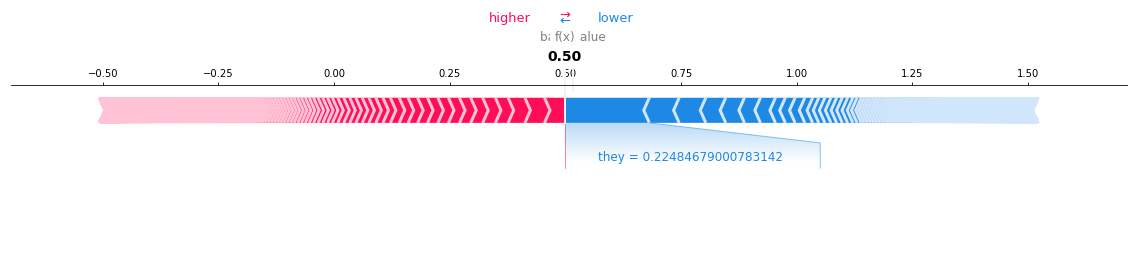

In [56]:
cluster_id = 1
indices = np.where(kmeans.labels_ == cluster_id)  
shap.force_plot(explainer.expected_value, shap_values_pool[indices][2], x_pool[indices][2],
                feature_names=tfid.get_feature_names(), matplotlib=True)

In [ ]:
shap_values_pool.shape

In [ ]:
df_final_labels.to_csv('df_input.csv')

In [ ]:
centroid_indices

In [ ]:
shap_values_pool.shape

In [ ]:
homogeneity_scores = []
v_measure_scores = []
completeness_scores = []
n_iters = 10
ranges = list(range(10, 110, 10))
for k in ranges:
    vavg = 0
    havg = 0
    cavg = 0
    for i in range(n_iters):
        kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1)
        kmeans.fit(shap_values_pool)
        v = v_measure_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        h = homogeneity_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        c = completeness_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        vavg += v
        havg += h
        cavg += c
    homogeneity_scores.append(havg/n_iters)
    v_measure_scores.append(vavg/n_iters)
    completeness_scores.append(cavg/n_iters)
    print(k, "done")



In [ ]:
data = [go.Scatter(x=ranges, y=homogeneity_scores, mode="lines", name="homogeneity"),
        go.Scatter(x=ranges, y=v_measure_scores, mode="lines", name="v_measure"),
        go.Scatter(x=ranges, y=completeness_scores, mode="lines", name="completeness")
        ]
fig = go.Figure(data=data)
fig.update_layout(xaxis_title="no of clusters")
fig.show()